In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os 
for dirname, _, filenames in os.walk('train'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

import torch
import torch.nn as nn
import torch.nn.functional as F

import pennylane as qml

import os

In [3]:
base_path = "train"

**Test Image display**

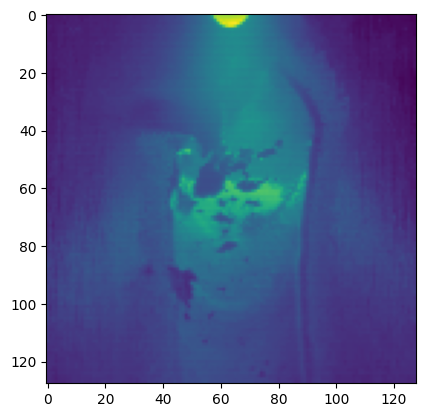

In [4]:
image = mpimg.imread(os.path.join(base_path, "2/170913-143933-Al 2mm-part2_frame_00562.png"))

plt.imshow(image)
plt.show()

In [5]:
image.shape

(128, 128)

**Main Code starting now**

Parameters

In [6]:
# num_quantum_features = 8
# num_layers = 4

num_quantum_features = 4
num_layers = 3

dev = qml.device("default.qubit", wires=num_quantum_features)

In [7]:
def layer(weights_0, weights_1, num_qubits):
    # Adding the Rot gates and the CNOT gates
    for wire in range(num_qubits):
        qml.Rot(*weights_0[wire], wires=wire)

    for wire in range(num_qubits):
        qml.CNOT([wire, (wire+1)%num_qubits])

    # Adding the SEL part
    if weights_1 is not None:
        for wire in range(num_qubits):
            y_val, z_val, x_val = weights_1[wire]
    
            qml.RY(y_val, wires=wire)
            qml.RZ(z_val, wires=wire)
            qml.RX(x_val, wires=wire)

In [8]:
## shape of weights = (num_layers x ([[rot...], [Wp...]]))

@qml.qnode(dev)
def qnode(inputs, encoding, weights_0, weights_1):
    # print("lenght of inputs:", len(inputs))
    # print("lenght of encoding:", encoding.shape)
    # print("lenght of weights_0:", weights_0.shape)
    # print("lenght of weights_1:", weights_1.shape)
    
    n_qubits = num_quantum_features
    n_layers = len(weights_0)-1
    
    for layer_num in range(n_layers):
        layer(weights_0[layer_num], weights_1[layer_num], n_qubits)

        for wire in range(n_qubits):
            qml.RZ((2**layer_num)*encoding[wire], wires=wire)

    layer(weights_0[n_layers], None, n_qubits)
    return [qml.expval(qml.Z(i)) for i in range(n_qubits)]

In [9]:
weight_shapes = {"encoding": (num_quantum_features, 1), "weights_0": (num_layers, num_quantum_features, 3), "weights_1": (num_layers - 1, num_quantum_features, 3)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

**Your Normal Classical PyTorch Model**

In [10]:
# # # Using it in one model

# # class PHN(nn.Module):
# #     def __init__(self, qlayer):
# #         super(PHN, self).__init__()

# #         # # For image of shape (3, 128, 128)
# #         # self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
# #         # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
# #         # self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
# #         # self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
# #         # self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)

# #         # For image of shape (3, 180, 180)
# #         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
# #         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
# #         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
# #         self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
# #         self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5)
        
# #         self.dense1 = nn.Linear(128, 64)
# #         self.bn1 = nn.BatchNorm1d(64)
        
# #         self.dense2 = nn.Linear(64, 32)
# #         self.bn2 = nn.BatchNorm1d(32)
        
# #         self.dense3 = nn.Linear(32, 8)
# #         self.bn3 = nn.BatchNorm1d(8)
        
# #         self.pool = nn.MaxPool2d(2, 2)
# #         self.d1 = nn.Dropout(0.2)
        
# #         # Following is for the parallel part
        
# #         self.dense4 = nn.Linear(8, 16)
# #         self.bn4 = nn.BatchNorm1d(16)
# #         self.ln4 = nn.LayerNorm(16)
        
# #         self.dense5 = nn.Linear(16, 32)
# #         self.bn5 = nn.BatchNorm1d(32)
# #         self.ln5 = nn.LayerNorm(32)
        
# #         self.dense6 = nn.Linear(32, 32)
# #         self.bn6 = nn.BatchNorm1d(32)
# #         self.ln6 = nn.LayerNorm(32)
        
# #         self.dense7 = nn.Linear(32, 16)
# #         self.bn7 = nn.BatchNorm1d(16)
# #         self.ln7 = nn.LayerNorm(16)
        
# #         self.dense8 = nn.Linear(16, 8)
# #         self.bn8 = nn.BatchNorm1d(8)
# #         self.ln8 = nn.LayerNorm(8)

# #         self.dense_x_para = nn.Linear(16, 8)
        
# #         # After the parallel part
        
# #         self.merge_layer = nn.Linear(16, 8)
# #         # self.merge_layer = nn.Linear(8, 8)
        
# #         self.bn_merge_layer = nn.BatchNorm1d(8)
# #         self.ln_merge_layer = nn.LayerNorm(8)
        
# #         self.densef = nn.Linear(8, 6)

# #         self.qlayer = qlayer

# #         self.softmax = nn.Softmax(dim=1)

# #     def forward(self, x):
# #         x = F.relu(self.conv1(x))
# #         x = self.pool(x)
# #         x = F.relu(self.conv2(x))
# #         x = self.pool(x)
# #         x = F.relu(self.conv3(x))
# #         x = self.pool(x)
# #         x = F.relu(self.conv4(x))
# #         x = self.pool(x)
# #         x = F.relu(self.conv5(x))
# #         x = self.pool(x)

# #         # x = x.view(-1, 32 * 3 * 3)
# #         x = nn.Flatten()(x)
# #         # print("shape of tensor after flatten:", x.shape)

# #         x = F.relu(self.dense1(x))
# #         # print("shape of tensor after dense1:", x.shape)
# #         x = self.d1(x)
# #         # print("shape of tensor after dropout:", x.shape)
# #         x = self.bn1(x)
# #         # print("shape of tensor after bn1:", x.shape)
# #         x = F.relu(self.dense2(x))
# #         x = self.d1(x)
# #         x = self.bn2(x)
# #         x = F.relu(self.dense3(x))
# #         x = self.d1(x)
# #         x_para = self.bn3(x)
# #         print("x_para:", x_para)
# #         print("x_para shape:", x_para.shape)

# #         # Comment/Uncomment the following lines for Hybrid Quantum Thing

# #         # x_para_ = x_para.view(1, -1)
# #         # print("x_para after flatten:", x_para_)
# #         # print("x_para after flatten shape:", x_para_.shape)
# #         # x_para_ = F.relu(self.dense_x_para(x_para_))
# #         # x_para_ = self.d1(x_para_)

# #         x_para_ = x_para
# #         print("shape of x_para_:", x_para_.shape)
        
# #         x_para_sig_ = torch.sigmoid(x_para_)
# #         print("x_para_sig_:", x_para_sig_)
# #         print("x_para_sig_ shape:", x_para_sig_.shape)
        
# #         x_para_sig_quantum, x_para_sig_classical = torch.split(x, 1, dim=0)

# #         print("x_para_sig_quantum shape:", x_para_sig_quantum.shape)
# #         # x_para_sig_q_ = self.qlayer(x_para_sig_)
# #         x_para_sig_q_ = self.qlayer(x_para_sig_quantum)
# #         print("x_para_sig_q_ shape:", x_para_sig_q_.shape)

# #         print("x_para_sig_classical shape:", x_para_sig_classical.shape)
# #         # x = F.relu(self.dense4(x_para_sig_))
# #         x = F.relu(self.dense4(x_para_sig_classical))
# #         print("Shape of x after dense4:", x.shape)
# #         x = self.d1(x)
# #         print("Shape of x after dense4 d1:", x.shape)
# #         # x = self.bn4(x)
# #         # print("Shape of x after dense4 d1 bn4:", x.shape)
# #         x = self.ln4(x)
# #         print("Shape of x after dense4 d1 ln4:", x.shape)
        
# #         x = F.relu(self.dense5(x))
# #         x = self.d1(x)
# #         # x = self.bn5(x)
# #         x = self.ln5(x)
        
# #         x = F.relu(self.dense6(x))
# #         x = self.d1(x)
# #         # x = self.bn6(x)
# #         x = self.ln6(x)
        
# #         x = F.relu(self.dense7(x))
# #         x = self.d1(x)
# #         # x = self.bn7(x)
# #         x = self.ln7(x)
        
# #         x = F.relu(self.dense8(x))
# #         x = self.d1(x)
# #         # x = self.bn8(x)
# #         x = self.ln8(x)

# #         # # Comment/Uncomment the following lines for Hybrid Quantum Thing
# #         x_para_sig = torch.sigmoid(x)
# #         print("shape of x_para_sig at concat:", x_para_sig.shape, x_para_sig_q_.shape)
        
# #         # x = torch.cat((x_para_sig, x_para_sig_q), dim=1)
# #         x = torch.cat((x_para_sig, x_para_sig_q_), dim=1)
# #         print("shape of x after concat:", x.shape)

# #         x = F.relu(self.merge_layer(x))
# #         x = self.d1(x)
# #         # x = self.bn_merge_layer(x)
# #         x = self.ln_merge_layer(x)

# #         x = self.densef(x)
# #         x = self.softmax(x)

# #         return x

# class PHN(nn.Module):
#     def __init__(self, qlayer):
#         super(PHN, self).__init__()

#         # # Convolutional layers for input shape (3, 180, 180)
#         # self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
#         # self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
#         # self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
#         # self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
#         # self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5)

#         # Convolutional layers for input shape (3, 180, 180) but lighter (upper one takes forever to train)
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5)
#         self.conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3)
#         self.conv4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
#         self.conv5 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)

#         self.pool = nn.MaxPool2d(2, 2)
#         self.d1 = nn.Dropout(0.2)

#         # Fully connected layers
#         self.dense1 = nn.Linear(32 * 2 * 2, 64)  # Adjust input size after flattening
#         self.bn1 = nn.BatchNorm1d(64)
        
#         self.dense2 = nn.Linear(64, 32)
#         self.bn2 = nn.BatchNorm1d(32)
        
#         self.dense3 = nn.Linear(32, 16)
#         self.bn3 = nn.BatchNorm1d(16)

#         # Layers for parallel processing part
#         self.dense4 = nn.Linear(8, 16)
#         self.bn4 = nn.BatchNorm1d(16)
#         self.ln4 = nn.LayerNorm(16)
        
#         self.dense5 = nn.Linear(16, 32)
#         self.bn5 = nn.BatchNorm1d(32)
#         self.ln5 = nn.LayerNorm(32)
        
#         self.dense6 = nn.Linear(32, 32)
#         self.bn6 = nn.BatchNorm1d(32)
#         self.ln6 = nn.LayerNorm(32)
        
#         self.dense7 = nn.Linear(32, 16)
#         self.bn7 = nn.BatchNorm1d(16)
#         self.ln7 = nn.LayerNorm(16)
        
#         self.dense8 = nn.Linear(16, 8)
#         self.bn8 = nn.BatchNorm1d(8)
#         self.ln8 = nn.LayerNorm(8)

#         self.dense_x_para = nn.Linear(16, 8)
        
#         # Merging layers after parallel processing
#         # self.merge_layer = nn.Linear(16, 8)
#         self.merge_layer = nn.Linear(12, 8)
        
#         self.bn_merge_layer = nn.BatchNorm1d(8)
#         self.ln_merge_layer = nn.LayerNorm(8)

#         # Final output layer
#         self.densef = nn.Linear(8, 6)
        
#         # Quantum layer placeholder
#         self.qlayer = qlayer

#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         # Convolutional layers with pooling
#         # print("x shape 1:", x.shape)
        
#         x = F.relu(self.conv1(x))
#         # print("x shape 2.1:", x.shape)
#         x = self.pool(x)
#         # print("x shape 2.2:", x.shape)
#         x = F.relu(self.conv2(x))
#         # print("x shape 2.3:", x.shape)
#         x = self.pool(x)
#         # print("x shape 2.4:", x.shape)
#         x = F.relu(self.conv3(x))
#         # print("x shape 3:", x.shape)
#         x = self.pool(x)
#         # print("x shape 3.1:", x.shape)
#         x = F.relu(self.conv4(x))
#         # print("x shape 3.2:", x.shape)
#         x = self.pool(x)
#         # print("x shape 3.3:", x.shape)
#         x = F.relu(self.conv5(x))
#         # print("x shape 4.1:", x.shape)
#         x = self.pool(x)
#         # print("x shape 4.2:", x.shape)

#         # Flatten for fully connected layers
#         x = x.view(x.size(0), -1)
#         # print("x shape flatten:", x.shape)

#         # Dense layers with BatchNorm and Dropout
#         x = F.relu(self.dense1(x))
#         # print("x shape dense 1:", x.shape)
#         x = self.d1(x)
#         # print("x shape dense 1 d1:", x.shape)
#         x = self.bn1(x)
#         # print("x shape bn1:", x.shape)
        
#         x = F.relu(self.dense2(x))
#         # print("x shape dense 2:", x.shape)
#         x = self.d1(x)
#         # print("x shape dense 2 d1:", x.shape)
#         x = self.bn2(x)
#         # print("x shape bn2:", x.shape)
        
#         x = F.relu(self.dense3(x))
#         # print("x shape dense 3:", x.shape)
#         x = self.d1(x)
#         # print("x shape dense 3 d1:", x.shape)
#         x_para = self.bn3(x)
#         # print("x shape bn3:", x_para.shape, type(x_para))

#         # Parallel processing part
#         x_para_sig_ = torch.sigmoid(x_para)
#         # print("x shape x_para_sig_:", x_para_sig_.shape)
#         x_para_sig_quantum, x_para_sig_classical = torch.split(x_para_sig_, 8, dim=-1)
#         # print("x shape, x_para_sig_quantum, x_para_sig_classical:", x_para_sig_quantum.shape, 
#               # x_para_sig_classical.shape)

#         # Quantum layer processing
#         x_para_sig_q_ = []
#         for i in range(x_para_sig_quantum.shape[0]):
#             x_para_sig_q_item_temp = self.qlayer(x_para_sig_quantum[i])
#             x_para_sig_q_.append(x_para_sig_q_item_temp)
        
#         x_para_sig_q_ = torch.stack(x_para_sig_q_)
        
#         # x_para_sig_q_ = self.qlayer(x_para_sig_quantum[0])
#         # x_para_sig_q_ = x_para_sig_quantum
        
#         # print("type of x_para_sig_q_ and type of element also", type(x_para_sig_q_), type(x_para_sig_q_[0]))
#         # print("x shape x_para_sig_q_:", x_para_sig_q_.shape)

#         # Classical processing
#         x = F.relu(self.dense4(x_para_sig_classical))
#         # print("x shape dense 4:", x.shape)
#         x = self.d1(x)
#         # print("x shape dense 4 d1:", x.shape)
#         x = self.ln4(x)
#         # print("x shape ln4:", x.shape)
        
#         # x = F.relu(self.dense5(x))
#         # # print("x shape dense 5:", x.shape)
#         # x = self.d1(x)
#         # # print("x shape dense 5 d1:", x.shape)
#         # x = self.ln5(x)
#         # # print("x shape ln5:", x.shape)
        
#         # # x = F.relu(self.dense6(x))
#         # # # print("x shape dense 6:", x.shape)
#         # # x = self.d1(x)
#         # # # print("x shape dense 6 d1:", x.shape)
#         # # x = self.ln6(x)
#         # # # print("x shape ln6:", x.shape)
        
#         # x = F.relu(self.dense7(x))
#         # # print("x shape dense 7:", x.shape)
#         # x = self.d1(x)
#         # # print("x shape dense 7 d1:", x.shape)
#         # x = self.ln7(x)
#         # # print("x shape ln7:", x.shape)
        
#         x = F.relu(self.dense8(x))
#         # print("x shape  dense 8:", x.shape)
#         x = self.d1(x)
#         # print("x shape  dense 8 d1:", x.shape)
#         x = self.ln8(x)
#         # print("x shape ln8:", x.shape)

#         # Concatenate quantum and classical results
#         x = torch.cat((x, x_para_sig_q_), dim=1)
#         # print("x shape concat:", x.shape)

#         # Merge layer with normalization
#         x = F.relu(self.merge_layer(x))
#         # print("x shape merge_layer:", x.shape)
#         x = self.d1(x)
#         # print("x shape merge_layer d1:", x.shape)
#         x = self.ln_merge_layer(x)
#         # print("x shape ln_merge_layer:", x.shape)

#         # Final classification layer
#         x = self.densef(x)
#         # print("x shape densef:", x.shape)
#         x = self.softmax(x)
#         print("x shape final:", x.shape)

#         return x

class PHN(nn.Module):
    def __init__(self, qlayer):
        super(PHN, self).__init__()

        self.flatten = nn.Flatten()
        self.d1 = nn.Dropout(0.2)

        self.dense1 = nn.Linear(3 * 128 * 128, 64)  # Flattened image input
        self.bn1 = nn.BatchNorm1d(64)
        
        self.dense2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.dense3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)

        self.dense4 = nn.Linear(8, 16)
        self.bn4 = nn.BatchNorm1d(16)
        self.ln4 = nn.LayerNorm(16)
        
        self.dense5 = nn.Linear(16, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.ln5 = nn.LayerNorm(32)
        
        self.dense6 = nn.Linear(32, 32)
        self.bn6 = nn.BatchNorm1d(32)
        self.ln6 = nn.LayerNorm(32)
        
        self.dense7 = nn.Linear(32, 16)
        self.bn7 = nn.BatchNorm1d(16)
        self.ln7 = nn.LayerNorm(16)
        
        self.dense8 = nn.Linear(16, 8)
        self.bn8 = nn.BatchNorm1d(8)
        self.ln8 = nn.LayerNorm(8)

        self.dense_x_para = nn.Linear(16, 8)
        
        self.merge_layer = nn.Linear(12, 8)
        
        self.bn_merge_layer = nn.BatchNorm1d(8)
        self.ln_merge_layer = nn.LayerNorm(8)

        self.densef = nn.Linear(8, 6)
        
        self.qlayer = qlayer

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)

        x = F.relu(self.dense1(x))
        x = self.d1(x)
        x = self.bn1(x)
        
        x = F.relu(self.dense2(x))
        x = self.d1(x)
        x = self.bn2(x)
        
        x = F.relu(self.dense3(x))
        x = self.d1(x)
        x = self.bn3(x)
        x_para = x

        x_para_sig_ = torch.sigmoid(x_para)

        x_para_sig_quantum, x_para_sig_classical = torch.split(x_para_sig_, 8, dim=-1)

        x_para_sig_q_ = []
        for i in range(x_para_sig_quantum.shape[0]):
            x_para_sig_q_item_temp = self.qlayer(x_para_sig_quantum[i])
            x_para_sig_q_.append(x_para_sig_q_item_temp)
        
        x_para_sig_q_ = torch.stack(x_para_sig_q_)

        x = F.relu(self.dense4(x_para_sig_classical))
        x = self.d1(x)
        x = self.ln4(x)

        x = F.relu(self.dense8(x))
        x = self.d1(x)
        x = self.ln8(x)

        x = torch.cat((x, x_para_sig_q_), dim=1)

        x = F.relu(self.merge_layer(x))
        x = self.d1(x)
        x = self.ln_merge_layer(x)

        x = self.densef(x)
        x = self.softmax(x)

        return x


**Defining model object**

In [11]:
model = PHN(qlayer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
from torchsummary import summary

In [13]:
summary(model, input_size=(3, 128, 128))
# summary(model, input_size=(3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 49152]               0
            Linear-2                   [-1, 64]       3,145,792
           Dropout-3                   [-1, 64]               0
       BatchNorm1d-4                   [-1, 64]             128
            Linear-5                   [-1, 32]           2,080
           Dropout-6                   [-1, 32]               0
       BatchNorm1d-7                   [-1, 32]              64
            Linear-8                   [-1, 16]             528
           Dropout-9                   [-1, 16]               0
      BatchNorm1d-10                   [-1, 16]              32
       TorchLayer-11                       [-1]               0
       TorchLayer-12                       [-1]               0
           Linear-13                   [-1, 16]             144
          Dropout-14                   

**Optimizer and stuff**

In [15]:
opt = torch.optim.SGD(model.parameters(), lr=0.002)
loss = nn.CrossEntropyLoss()

In [16]:
if image.ndim == 2:
    image_expanded = np.stack((image,)*3, axis=0)

In [17]:
image_expanded.shape, image.shape

((3, 128, 128), (128, 128))

In [18]:
# Define the batch size
batch_size = 32  # You can choose any batch size

# Create a random input tensor
batch_input_tensor = torch.randn(batch_size, 3, 128, 128)  # Random tensor with shape (batch_size, 3, 128, 128)

# Print the shape of the input tensor
print(batch_input_tensor.shape)  # Should print: torch.Size([8, 3, 128, 128])

torch.Size([32, 3, 128, 128])


In [19]:
single_image_input = torch.randn(1, 3, 128, 128)  # A random single image

# Print the shape of the input tensor
print(single_image_input.shape)  # Should print: torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])


In [20]:
batch_input_tensor = batch_input_tensor.to(device)
single_image_input = single_image_input.to(device)

# model = model.to(device)

# model(single_image_input)
model(batch_input_tensor)

tensor([[0.2066, 0.2298, 0.1382, 0.1775, 0.0522, 0.1957],
        [0.1312, 0.1454, 0.3401, 0.1831, 0.0489, 0.1513],
        [0.1760, 0.0689, 0.2197, 0.1060, 0.3175, 0.1120],
        [0.4405, 0.2400, 0.0684, 0.0828, 0.0555, 0.1128],
        [0.4566, 0.1168, 0.0866, 0.0876, 0.1307, 0.1216],
        [0.2521, 0.0374, 0.1641, 0.1202, 0.2918, 0.1344],
        [0.4396, 0.1495, 0.0620, 0.1127, 0.1208, 0.1155],
        [0.1312, 0.1454, 0.3401, 0.1831, 0.0489, 0.1513],
        [0.1551, 0.2179, 0.2242, 0.0801, 0.1502, 0.1724],
        [0.5475, 0.0710, 0.0947, 0.0628, 0.1143, 0.1097],
        [0.5438, 0.0791, 0.1457, 0.0493, 0.0961, 0.0860],
        [0.4966, 0.0952, 0.0877, 0.0788, 0.1246, 0.1171],
        [0.0833, 0.1671, 0.3041, 0.0893, 0.1568, 0.1994],
        [0.0778, 0.2337, 0.1992, 0.1057, 0.1593, 0.2242],
        [0.5507, 0.1270, 0.0899, 0.0660, 0.0924, 0.0741],
        [0.1211, 0.1472, 0.2971, 0.0804, 0.1893, 0.1649],
        [0.1706, 0.0969, 0.3230, 0.0683, 0.2000, 0.1412],
        [0.065

**train and test division for the training and testing dataset**

In [84]:
# train_sub = image_dataset_from_directory(base_path,
#                                          labels="inferred",
#                                          label_mode="categorical",
#                                          image_size=(180, 180),
#                                          subset='training',
#                                          seed=1,
#                                          validation_split=0.2,
#                                          batch_size=32)

# test_sub = image_dataset_from_directory(base_path,
#                                         labels="inferred",
#                                         label_mode="categorical",
#                                         image_size=(180, 180),
#                                         subset='validation',
#                                         seed=1,
#                                         validation_split=0.2,
#                                         batch_size=32)

In [21]:
from torchvision import datasets, transforms

# transform = transforms.Compose([
#     transforms.Resize((180, 180)),
#     transforms.ToTensor()
# ])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [27]:
full_dataset = datasets.ImageFolder(root=base_path, transform=transform)

validation_split = 0.3
dataset_size = len(full_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

In [28]:
from torch.utils.data import DataLoader, random_split

train_sub, test_sub = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(1))

In [29]:
train_loader = DataLoader(train_sub, batch_size=32, shuffle=True)
test_loader = DataLoader(test_sub, batch_size=32, shuffle=True)

In [30]:
def calc_acc(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

In [31]:
num_epochs = 30
# num_epochs = 5
# num_epochs = 1

loss_at_epoch = []
acc_at_epoch = []

running_loss_at_epoch = []
running_acc_at_epoch = []

**Checking the train and test loaders**

In [32]:
batch_counter = 1
for inputs, labels in train_loader:
    # print("batch_counter:", batch_counter)
    # print("shape of inputs:", inputs.shape)
    # print("shape of labels:", labels.shape)
    batch_counter += 1

print("num batches:", batch_counter)

num batches: 585


In [95]:
batch_counter = 1
for inputs, labels in test_loader:
    # print("batch_counter:", batch_counter)
    # print("shape of inputs:", inputs.shape)
    # print("shape of labels:", labels.shape)
    batch_counter += 1

print("num batches in test loader:", batch_counter)

num batches in test loader: 251


**Continuing with training**

In [33]:
PATH = 'data'

In [34]:
import time

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    batch_counter = 1
    
    for inputs, labels in train_loader:
        start_time = time.time()
        print("epoch, batch_counter start:", epoch + 1, batch_counter)
        
        opt.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        l = loss(outputs, labels)

        print("l:", l)
        # print("output from model:", outputs)
        # print("labels in iteration:", labels)

        l.backward()
        opt.step()

        acc = calc_acc(outputs, labels)
        # if batch_counter == 1:
        if True:
            print("acc:", acc)

        loss_at_epoch.append(l.item())
        acc_at_epoch.append(acc)

        running_loss += l.item()
        running_acc += acc
        
        running_loss_at_epoch.append(running_loss)
        running_acc_at_epoch.append(running_acc)
        end_time = time.time()

        print("time taken:", end_time - start_time)
        batch_counter += 1

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    try:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': l,
            'loss_at_epoch': loss_at_epoch,
            'acc_at_epoch': acc_at_epoch,
            'running_loss_epoch': running_loss_at_epoch,
            'running_acc_epoch': running_acc_at_epoch
        }, PATH + 'epoch_' + str(epoch) + '.pth')
    except:
        print("Error in saving the model training params for the epoch")

epoch, batch_counter start: 1 1
l: tensor(1.7919, grad_fn=<NllLossBackward0>)
acc: 0.21875
time taken: 1.3828999996185303
epoch, batch_counter start: 1 2
l: tensor(1.8156, grad_fn=<NllLossBackward0>)
acc: 0.125
time taken: 0.9370841979980469
epoch, batch_counter start: 1 3
l: tensor(1.7366, grad_fn=<NllLossBackward0>)
acc: 0.3125
time taken: 1.2164552211761475
epoch, batch_counter start: 1 4
l: tensor(1.7970, grad_fn=<NllLossBackward0>)
acc: 0.1875
time taken: 0.816964864730835
epoch, batch_counter start: 1 5
l: tensor(1.7936, grad_fn=<NllLossBackward0>)
acc: 0.1875
time taken: 0.7931389808654785
epoch, batch_counter start: 1 6
l: tensor(1.7652, grad_fn=<NllLossBackward0>)
acc: 0.3125
time taken: 1.184826135635376
epoch, batch_counter start: 1 7
l: tensor(1.7355, grad_fn=<NllLossBackward0>)
acc: 0.375
time taken: 0.9255077838897705
epoch, batch_counter start: 1 8
l: tensor(1.8097, grad_fn=<NllLossBackward0>)
acc: 0.1875
time taken: 1.109724998474121
epoch, batch_counter start: 1 9
l: t

KeyboardInterrupt: 

In [35]:
model.eval()

PHN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (d1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=49152, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense4): Linear(in_features=8, out_features=16, bias=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln4): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (dense5): Linear(in_features=16, out_features=32, bias=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ln5): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dense6): Linear(in_fea

In [36]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        _,  preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

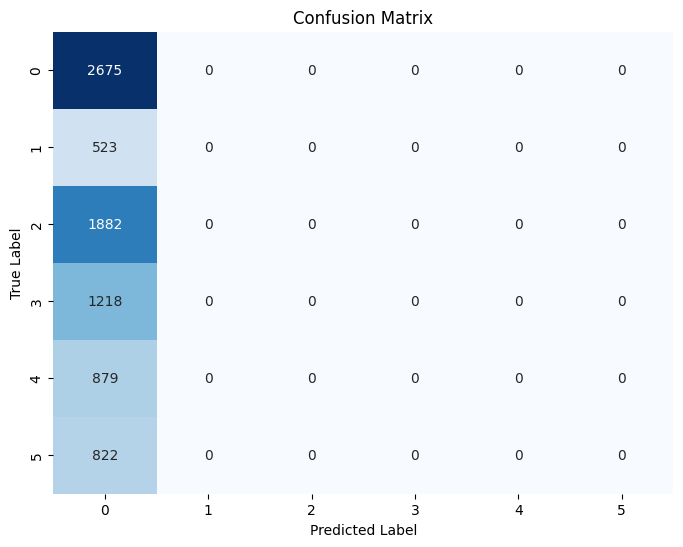

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [40]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict()
        }, PATH + 'epoch_' + str(epoch) + '.pth')